In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def read_data(filepath: str, offset: int = 0, data_length: int = None, data_type: str ='int16') -> pd.DataFrame:
    """Фукнция для считывания данных из бинарных файлов

    Args:
        filepath (str): Путь до файла.
        offset (int, optional): Количество наблюдений, которое нужно пропустить сначала. Defaults to 0.
        data_length (int, optional): Необходимое количество наблюдений. Если не передавать никакого значения, будут считаны все данные, начиная с offset. Defaults to None.
        data_type (str, optional): Тип данных. Defaults to 'int16'.

    Returns:
        pd.DataFrame: Итоговая таблица. Столбцы right, top, left, bottom отвечают за данные с четырех пикапов.
    """

    # Считывание данных в один вектор
    line_data = np.fromfile(filepath, dtype=data_type)
    # Разделение вектора на четыре столбца матрицы, каждый из которых соответствует пикапу
    data = line_data.reshape(-1, 4)
    # Формирование датафрейма на основе предыдущей матрицы
    data = pd.DataFrame(data, columns=['right', 'top', 'left', 'bottom'])
    # Если не передано никакого значения в data_length, то будут браться все значение, начиная с offset
    if data_length is None: data_length = len(data) - offset
    # Из полученного датафрейма делается срез, начиная с offset, длинной data_length. в котором сбрасываются индесы (чтобы они начинались с нуля)
    data = data.iloc[offset: offset + data_length].reset_index().drop('index', axis=1)
    return data

In [4]:
def fft_with_corrected_frequences(data: np.ndarray, corrected_frequences: np.ndarray, number_of_samples: int = 256, number_of_values: int = None) -> np.ndarray:
    """Прямое преборазование Фурье с учетом корректировочных частот

    Args:
        data (np.ndarray): Вектор данных
        corrected_frequences (np.ndarray): Вектор корректировочных частот
        number_of_samples (int, optional): Число отсчетов для преобразования Фурье. Для корректной работы должно быть степенью двойки. Defaults to 256.
        number_of_values (int, optional): Число итоговых знячений. По умолчанию, выводятся все. Defaults to None.

    Returns:
        np.ndarray: Преобразованный вектор
    """

    # Преобразование данных в формат np.ndarray для корректной работы
    data = np.array(data)
    # Если number_of_values не был задан, берутся все значение
    if number_of_values is None: number_of_values = len(data)
    # Реализация прямого преобразования Фурье с корректировочными частотами (2j означает 2 * мнимую единицу)
    return np.fromiter((data[:number_of_samples] @
            np.exp(2j * np.pi * corrected_frequences[i] * np.arange(number_of_samples))
            for i in range(number_of_values)), 'complex')

In [5]:
def find_period(data: np.ndarray, number_of_samples: int = 32*2048, sample_length: int = 10, period_correction: float = 0.005,
                number_of_amplitudes_for_corrected_period: int = 20, half_window_length: int = 5) -> float:
    """Поиск периода в данных с помощью преобразования Фурье со сглаживанием и корректировочными частотами

    Args:
        data (np.ndarray): Вектор данных
        number_of_samples (int, optional): Число отсчетов для преобразования Фурье. Defaults to 32*2048.
        sample_length (int, optional): Длина окна, в котором выполняется сглаживание методом среднего. Defaults to 10.
        period_correction (float, optional): Изменение периода, относительно которого происходит корректировка. Defaults to 0.005.
        number_of_amplitudes_for_corrected_period (int, optional): Число амплитуд после второй корректировки. Defaults to 21.
        half_window_length (int, optional): Дляга полуокна, в котором будет производится регрессия. Defaults to 5.

    Returns:
        float: Значение периода
    """

    # Перевод данных в формат np.ndarray для корректной работы
    data = np.array(data)
    # Разделение данных на numer_of_samples участков по sample_length значений для последующего сглаживания
    sampled_data = data[:(number_of_samples * sample_length)].reshape(-1, sample_length)
    # Сглаживание данных на каждом из участков посредством усреднения
    smoothed_data = pd.DataFrame(sampled_data.T).mean().to_numpy()
    # Применение прямого преобразования Фурье для сглаженных данных. Нахождение амплитуд
    fourier_decomposition_amplitudes = np.abs(scipy.fft.fft(smoothed_data, norm='forward'))
    # Нахождение несущей частоты для полученных амплитуд
    carrier_frequency = np.argmax(fourier_decomposition_amplitudes)
    # Проверка на неравенство несущей частоты нулю
    if carrier_frequency == 0: raise ValueError("Incorrect_data. Carrier frequency can't be zero")
    # Нахождения периода в данных после сглаживания
    period_after_smoothing = number_of_samples * sample_length / carrier_frequency
    # Нахождение корректировочных периодов
    corrected_periods = period_after_smoothing * (1 + period_correction * (2*np.arange(number_of_amplitudes_for_corrected_period + 1)
                                                                           / number_of_amplitudes_for_corrected_period - 1)) # Уточненные периоды для каждого окна
    # Применение прямого преобразования Фурье к данным с учетом корректировочных периодов. Нахождение амплитуд
    fourier_decomposition_amplitudes_with_corrected_periods = 1 / (number_of_samples * sample_length) *\
        np.abs(fft_with_corrected_frequences(data, 1 / corrected_periods,
                                      number_of_samples*sample_length,
                                      number_of_amplitudes_for_corrected_period))
    # Нахождение несущей частоты  (или несущего периода) для полученных на предыдущем шаге амплитудах
    carrier_frequency_in_corrected_spectrum = np.argmax(fourier_decomposition_amplitudes_with_corrected_periods)
    # Нахождение значений отклонений от несущего периода. В данном случае, в обе стороны откладывается по half_window_length значений
    deviations_form_carrier_period_slice = corrected_periods[carrier_frequency_in_corrected_spectrum-half_window_length:
                                                             carrier_frequency_in_corrected_spectrum+half_window_length+1] -\
                                            carrier_frequency_in_corrected_spectrum
    # Аналогично, берется такое же окно для амплитуд.
    fourier_decomposition_amplitudes_with_corrected_periods_slice =\
        fourier_decomposition_amplitudes_with_corrected_periods[carrier_frequency_in_corrected_spectrum-half_window_length:
                                                                carrier_frequency_in_corrected_spectrum+half_window_length+1]
    # Построение квадратичной регрессии по отклонениям и амплитудам
    square_regressions_coefficients = np.polyfit(deviations_form_carrier_period_slice,
                                                fourier_decomposition_amplitudes_with_corrected_periods_slice, 2)
    # Нахождение итогового периода в данных
    data_period = carrier_frequency_in_corrected_spectrum - (square_regressions_coefficients[1]) / (2 * square_regressions_coefficients[0])

    return data_period

In [6]:
def get_beam_center_positions(summary_resonace: np.ndarray, difference_resonance: np.ndarray, period_length: float) -> np.ndarray:
    """Фукнция для вычисления координат центра масс по заданным суммарным и разностным резонансом для одной из осей.

    Args:
        summary_resonace (np.ndarray): Вектор суммарных резонансов по одной из осей.
        difference_resonance (np.ndarray): Вектор разностных резонансов по той же самой оси.
        period_length (float): Длина периода. Может быть дробной.

    Returns:
        np.ndarray: Вектор со значениями координаты центра масс для каждого из периодов по заданной оси.
    """

    # Вычисление общего количества периодов
    number_of_periods = int(len(summary_resonace) / period_length)
    # Задания вектора, с количеством элементов, равным числу периодов, для хранения полученных координат. Изначально заполнен нулями
    mass_center_positions = np.zeros(number_of_periods)
 
    # Запускаем цикл от 0 до number_of_periods-1 включительно с шагом 1. Грубо говоря, этим циклом мы пробегаемся по всем периодам
    for i in range(number_of_periods):

        # Находим срез, соответсвующий текущему периоду, для векторов summary_resonance и difference_resonance.
        # ВАЖНАЯ ДЕТАЛЬ. В данном случае, вручную задается тип int64, так как происходит переполнение изначального типа int16 при возведении значений в квадрат
        summary_resonance_period_slice = np.array(summary_resonace, 'int64')[int(i*period_length): int((i+1)*period_length)] 
        difference_resonance_period_slice = np.array(difference_resonance, 'int64')[int(i*period_length): int((i+1)*period_length)] 
 
        # Вычисление промежуточных параметров. Автор не особо осведомлен об их природе, поэтому тут могут потребоваться дополнительные пояснения
        m_11 = float(np.sum(summary_resonance_period_slice**2))
        m_12 = float(np.sum(summary_resonance_period_slice)) 
 
        y_1 = float(summary_resonance_period_slice @ difference_resonance_period_slice) 
        y_2 = float(np.sum(difference_resonance_period_slice)) 

        # Вычисление значения координаты центра масс для текущего периода. Добавление ее в итоговый вектор
        mass_center_positions[i] = ((m_12 * y_2) - (np.floor(period_length) * y_1)) / (m_12 ** 2 - m_11 * np.floor(period_length)) 
 
    return mass_center_positions

In [7]:
# WARNING!!! Данная функция пока еще не была протестирована для правой части спектра
def get_spectrum(beam_center_coordinates: np.ndarray, number_of_samples: int = 2**8, offset: int = 3, is_left_part: bool = True) -> tuple:
    """Функция для нахождения спектра дробной части бетатронной частоты.

    Args:
        beam_center_coordinates (np.ndarray): Вектор координат центров масс пучка по одной из осей.
        number_of_samples (int, optional): _description_. Число отсчетов для дискретного преобразования Фурье. Для корректной работы должно быть степенью двойки. Defaults to 2**8.
        offset (int, optional): _description_. Количество частот, которые мы пропускаем сначала (т.е. считаем их амплитуду нулевой). Defaults to 3.
        is_left_part (bool, optional): _description_. Флаг, отвечающий за интересующую часть спектра. Если True - берется левая часть спектра (частота меньше 0.5).
            Если False - правая (частота больше 0.5). Defaults to True.

    Returns:
        tuple: Возвращает кортеж с двумя векторами типов np.ndarray: frequences - значения частот, amplitudes - значения соответствующих им амплитуд.
    """

    # Применяем прямое преобразование Фурье для первый number_of_samples координат центров масс. Для получения нужной нормировки, делим на number_of_samples
    fourier_transformed_vector = scipy.fft.fft(np.array(beam_center_coordinates)[:number_of_samples]) / number_of_samples
    # Заполняем первые offset значений нулями и оставляем только первую половину значений от преобразованного вектора. В дальнейшем, если будет нужна правая часть, это преобразуется
    sliced_fourier_transformed_vector = np.concatenate([np.zeros(offset), fourier_transformed_vector[3: number_of_samples // 2]])
    # Находим амплитуды сигналов, находя абсолютные значения для каждой из величин преобразованного вектора
    amplitudes = np.abs(sliced_fourier_transformed_vector)

    # С помощью данного ветвления происходит выбор между правой и левой частями спектра
    if is_left_part:
        # Если левая часть спектра, то частоты берутся от 0 до 0.5
        frequences = np.arange(0, 0.5, 1 / number_of_samples)
    else:
        # WARNING!!! Данная часть не тестировалась. Возможные ошибки:
        # 1. Неправильный порядок частот или амплитуд. Можно попытаться отразить порядок следования элементов в массиве. Например, amplitudes = amplitudes[::-1].
        # 2. Небольшое смещение частот. Для этого, при расчете frequences нужно убрать слагаемое "+ 1 / number_of periods"

        # Если правая часть спектра, то сначала нужно преобразовать амплитуды
        amplitudes = 1 - amplitudes
        # Частоты берутся от 0.5 до 1
        frequences = np.arange(0.5, 1, 1 / number_of_samples) + 1 / number_of_samples

    return frequences, amplitudes

In [8]:
def find_main_frequence(frequences: np.ndarray, amplitudes: np.ndarray, slice_percentage: float = 0.5) -> float:
    """Функция для нахождения основной частоты спектра.

    Args:
        frequences (np.ndarray): Вектор частот спектра.
        amplitudes (np.ndarray): Вектор амплитуд спектра.
        slice_percentage (float, optional): Параметр, отвечающий за долю значений, которые будут расматриваться (автор не до конца в этом уверен)/
            По умолчанию, берутся все значения. Defaults to 0.5.

    Raises:
        ValueError: Возникает, если frequences и amplitudes имеют разную длину.

    Returns:
        float: Значение основной частоты
    """

    # Проверка на соответствие длин frequences и amplitudes. При несоответсвии выдается исключение
    if len(frequences) != len(amplitudes):
        raise ValueError('frequences and amplitudes must have same length')
    
    # Находим позицию, на которой находится значение максимальной из амплитуд вместе с соотвествующим срезом (умножение на двойку было в маткадовском коде,
    # если его убрать, то значение по умолчанию для slice_percentage нужно сделать равным единице).
    main_frequence_index = np.argmax(amplitudes[:int(slice_percentage * 2 * len(frequences))])
    # Выделяем частоту, которая находится на найденной выше позиции.
    main_frequence = frequences[main_frequence_index]
    return main_frequence

In [9]:
def plot(data: pd.DataFrame, period: int, number_of_periods: int, start_record_number: int=0, columns=None, **plot_params):
    columns = columns if columns else data.columns
    data[start_record_number: start_record_number + number_of_periods*period][columns].plot(**plot_params)
    for i in range(number_of_periods+1):
        plt.axvline(x=start_record_number+i*period, ls='--', color='gray')

# Считывание и предобработка данных

In [10]:
sns.set_theme()

In [11]:
offset = 8 * 6300 // 2 // 4
len_data = 4 * 1024**2 // 4

In [12]:
data = read_data(r'bpm_data/11_01_booster_libera08_hbpm3_1_full', offset=offset, data_length=len_data)
data

,right,top,left,bottom
0,-147,-273,-406,79
1,-157,-196,-416,321
2,17,-124,-416,383
3,373,-29,-415,230
4,247,-82,-421,-149
...,...,...,...,...
1048571,496,365,32,438
1048572,526,141,228,682
1048573,614,271,132,356
1048574,486,376,130,-11


In [13]:
summary_resonance = pd.DataFrame()
summary_resonance['X'] = data['right'] + data['left']
summary_resonance['Y'] = data['top'] + data['bottom']

difference_resonance = pd.DataFrame()
difference_resonance['X'] = data['right'] - data['left']
difference_resonance['Y'] = data['top'] - data['bottom']

In [14]:
period = find_period(summary_resonance['X'])
period

2128.751497045826

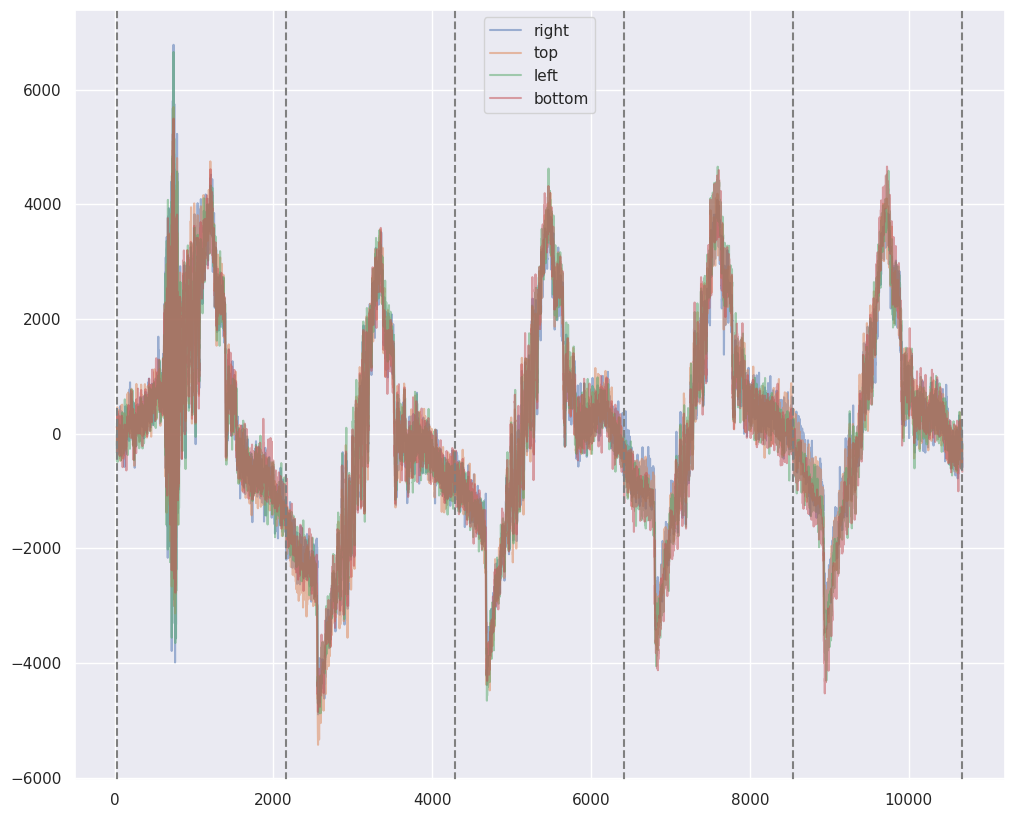

In [24]:
plot(data, period=round(period), number_of_periods=5, start_record_number=29, figsize=(12, 10), alpha=0.5)

# Нахождение координат центров масс

In [15]:
plate_size = {}
plate_size['X'] = 64
plate_size['Y'] = 33

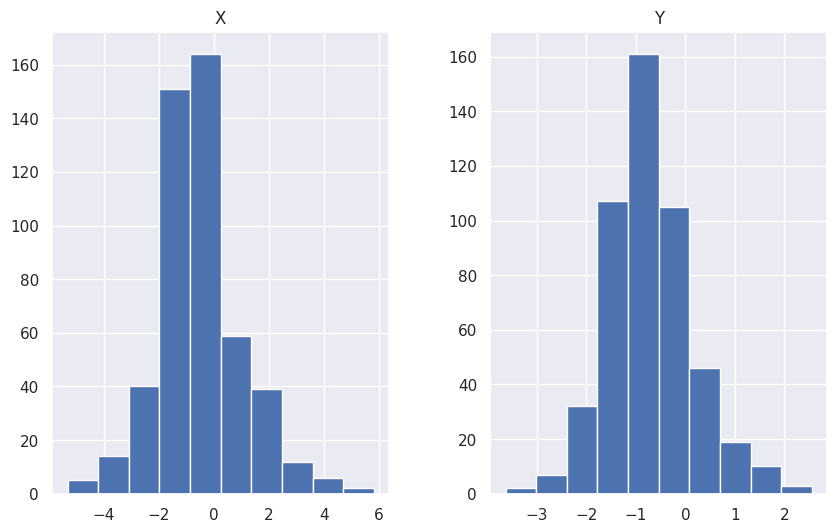

In [20]:
beam_center_coords = pd.DataFrame()
for axis in ['X', 'Y']:
    beam_center_coords[axis] = plate_size[axis] * get_beam_center_positions(summary_resonance[axis], difference_resonance[axis], period)
beam_center_coords.hist(figsize = (10, 6));

# Нахождение спектра и несущих частот

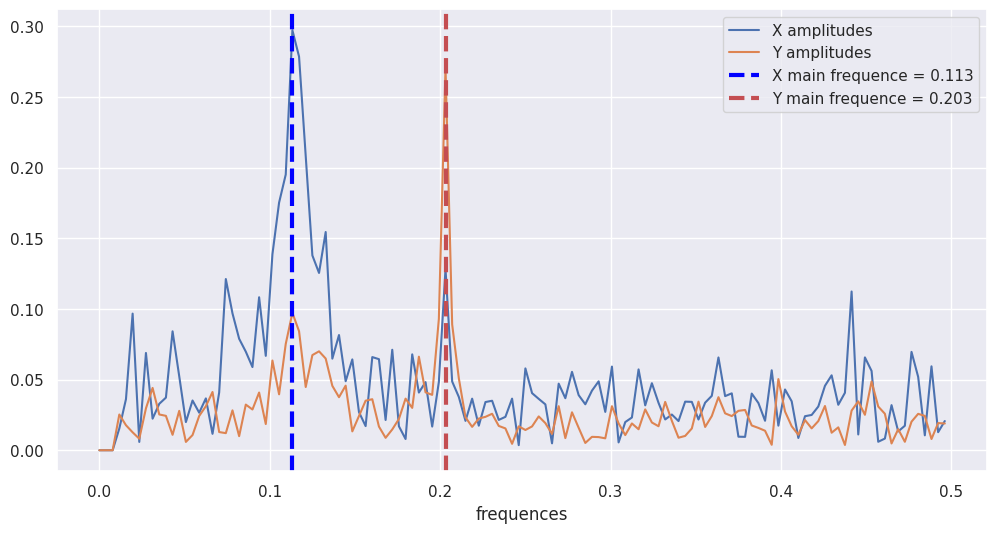

In [21]:
spectrum = pd.DataFrame()
main_frequences = {}
for axis in 'X', 'Y':
    freq, amp = get_spectrum(beam_center_coords[axis])
    spectrum[axis + ' amplitudes'] = amp
    main_frequences[axis] = find_main_frequence(freq, amp) 
spectrum['frequences'] = freq
spectrum = spectrum.set_index('frequences')

spectrum.plot(figsize=(12, 6))
plt.axvline(main_frequences['X'], ls='--', c='blue', lw=3, label=f'X main frequence = {round(main_frequences["X"], 3)}')
plt.axvline(main_frequences['Y'], ls='--', c='r', lw=3, label=f'Y main frequence = {round(main_frequences["Y"], 3)}')
plt.legend();

# Tune chromacity

## Маткадовское

In [31]:
vx = main_frequences['X'] - 0.01
vy = main_frequences['Y'] - 0.03

In [ ]:
find_theoretical = {}
find_theoretical['X'] = lambda n: 5 * np.cos(2 * np.pi * vx * n + 0.4) * np.exp(-(n**2) / (2 * 18**2)) 
find_theoretical['Y'] = lambda n: 2 * np.cos(2 * np.pi * vy * (n - 40) + 0.) * np.exp(-(n**2) / (2 * 45**2))

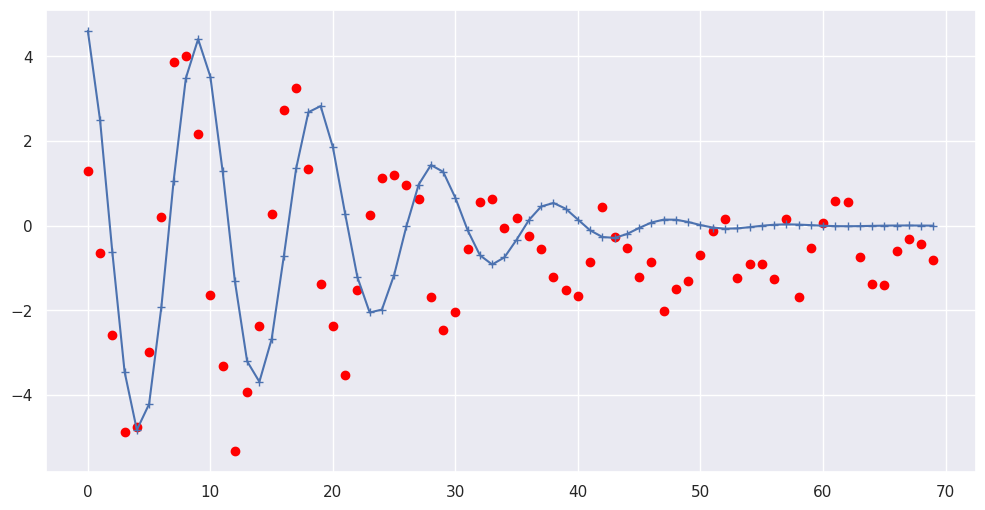

In [152]:
t = np.arange(70)
plt.figure(figsize=(12, 6))
plt.plot(t, find_theoretical['X'](t), marker="+")
plt.scatter(t, beam_center_coords['X'][t], color='red');

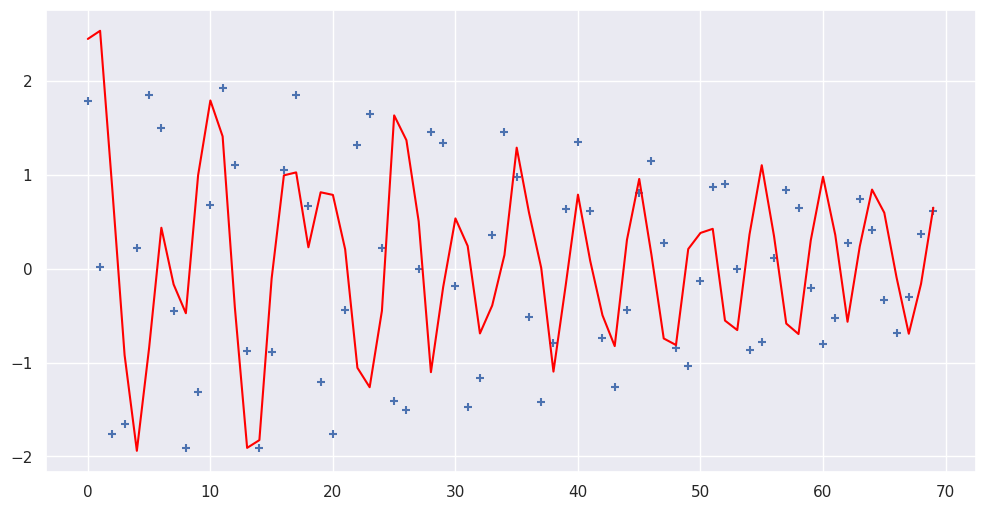

In [106]:
t = np.arange(70)
plt.figure(figsize=(12, 6))
plt.scatter(t, find_theoretical['Y'](t), marker="+")
plt.plot(t, beam_center_coords['Y'][t]+1, color='red');

## Мое

In [226]:
def damped_oscillations_fit(x_data, y_data, bounds = None):

    default_bounds = {'A': (0, np.inf), 'omega': (-np.inf, np.inf),
                    'phi': (0, 2*np.pi), 'beta': (0, np.inf), 'bias': (-np.inf, np.inf)}

    if bounds is None: bounds = default_bounds

    bounds_list = [[0]*5, [0]*5]
    for i, parameter_name in enumerate(('A', 'omega', 'phi', 'beta', 'bias')):
        if parameter_name not in bounds: bounds[parameter_name] = default_bounds[parameter_name]
        bounds_list[0][i] = bounds[parameter_name][0]
        bounds_list[1][i] = bounds[parameter_name][1]

    damped_oscillations_function = lambda t, A, omega, phi, beta, bias: A * np.exp(-beta*t) * np.cos(omega*t + phi) + bias
    
    A, omega, phi, beta, bias = scipy.optimize.curve_fit(damped_oscillations_function, x_data, y_data, bounds=bounds_list)[0]

    result_function = lambda t: A * np.exp(-beta*t) * np.cos(omega*t + phi) + bias
    
    return result_function, {'A': A, 'omega': omega, 'phi': phi, 'beta': beta, 'bias': bias}

In [263]:
function = {}

bounds = {
    'X': {'omega': (2*np.pi*main_frequences['X'] - 0.01, 2*np.pi*main_frequences['X'] + 0.01), 'A': (2, np.inf)},
    'Y': {'omega': (2*np.pi*main_frequences['Y'] - 0.01, 2*np.pi*main_frequences['Y'] + 0.01), 'A': (3, 4), 'beta': (0, .02)}}

slice_length = {'X': 100, 'Y': 100}

for axis in 'XY':
    t = np.arange(slice_length[axis])
    function[axis], parameters  = damped_oscillations_fit(t, beam_center_coords[axis][t], bounds=bounds[axis])

    print(f'''Параметры для {axis}:
          A = {parameters['A']}
          v = {parameters['omega'] / (2 * np.pi)} (theoretical = {main_frequences[axis]})
          phi = {parameters['phi']}
          beta = {parameters['beta']}
          bias = {parameters['bias']}''')

Параметры для X:
          A = 5.44574787522552
          v = 0.11417531842838853 (theoretical = 0.11328125)
          phi = 0.743825385556685
          beta = 0.03806358949456314
          bias = -0.7163105423627149
Параметры для Y:
          A = 3.0000000000000004
          v = 0.20351031617311124 (theoretical = 0.203125)
          phi = 5.1312651730934995
          beta = 0.019999999999999997
          bias = -0.9056115802362817


In [268]:
beam_center_coords['Y'].mean()

-0.712479288471354

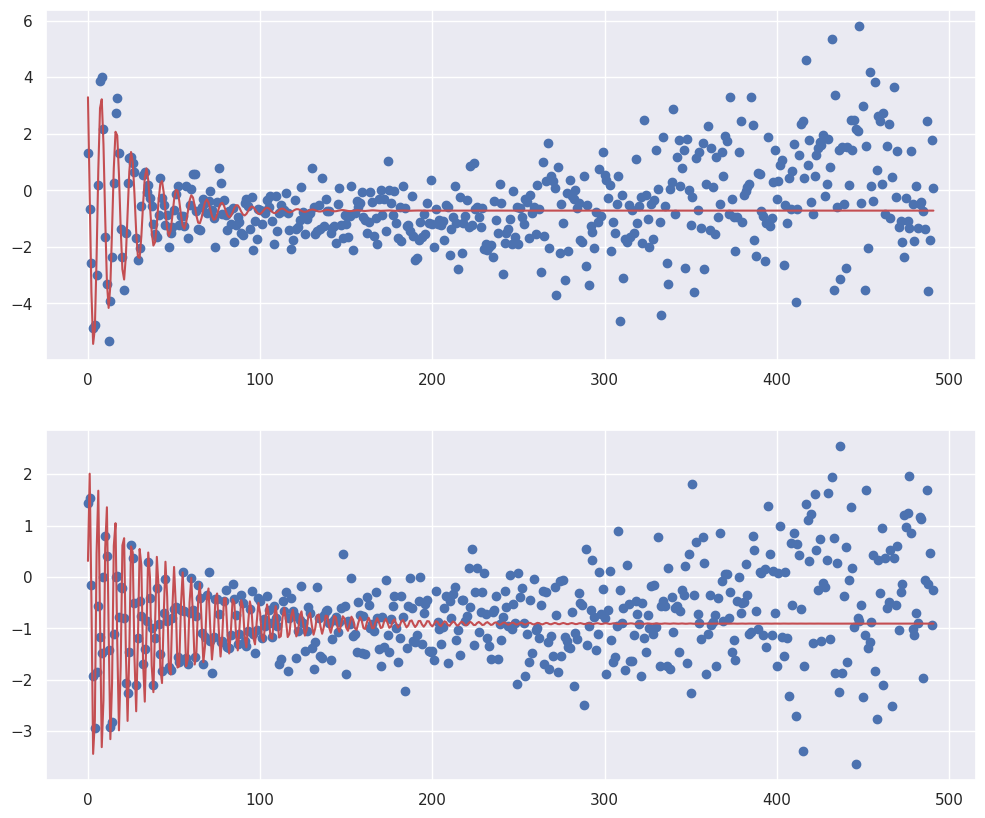

In [266]:
t = np.arange(492)
theoretical_values = pd.DataFrame()
for axis in 'XY':
    theoretical_values[axis] = function[axis](t)

fig, axs = plt.subplots(2, figsize=(12, 10))
axs[0].scatter(t, beam_center_coords['X'])
axs[0].plot(t, theoretical_values['X'], color='r')

axs[1].scatter(t, beam_center_coords['Y'])
axs[1].plot(t, theoretical_values['Y'], color='r');